# Non-Unitary Operators for the Non-Hermitian Skin Effect

Paper to be replicated: https://arxiv.org/pdf/2311.10143

Addition Resources Consulted:
- https://link.aps.org/pdf/10.1103/PRXQuantum.2.010342
- https://medium.com/mdr-inc/time-evolution-operators-be2968493b86 (note there are some notable errors)
- 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
# from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector

# from tqdm.notebook import tqdm

from numpy import sin, cos
import numpy as np
from scipy.linalg import expm, sqrtm

from scipy.optimize import differential_evolution, dual_annealing, minimize

from itertools import product

import random

import json

import csv





In [3]:
# service = QiskitRuntimeService()
BACKEND = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=BACKEND, optimization_level=0)
estimator = Estimator(mode=BACKEND)
sampler = Sampler(mode=BACKEND)

## I. Hatano-Nelson Model

Note $\hat{X}^+ = \frac{\hat{X} + i \hat{Y}}{2}$ and $\hat{X}^- = \frac{\hat{X} - i \hat{Y}}{2}$

In [4]:
X_gate = np.array([[0, 1], 
                   [1, 0]])

Y_gate = np.array([[0, -1j],
                   [1j, 0]])

I_gate = np.array([[1, 0], 
                   [0, 1]])

X_plus = 0.5 * (X_gate + 1j * Y_gate)
X_minus = 0.5 * (X_gate - 1j * Y_gate)

In [5]:
# Helper function, generates U_j_nonH
def get_U_j_nonH(J, gamma, index, N, timestep):
    product_1 = np.kron(X_plus, X_minus)
    product_2 = np.kron(X_minus, X_plus)
    exponent = 1j * timestep * ( (J - gamma) * product_1 + (J + gamma) * product_2)
    
    if index == 0:
        U_j_nonH = np.kron(np.eye(2 ** (N-2)), expm(exponent))
    if index == N - 2:
        U_j_nonH = np.kron(expm(exponent), np.eye(2 ** (N-2)))
    else: 
        U_j_nonH = np.kron(np.kron(np.eye(2 ** (N - 2 - index)), expm(exponent)), np.eye(2 ** (index)))
    return U_j_nonH
    


# Helper function, generates R_HN
def get_R_HN(J, gamma, N, timestep):
    res_even = np.eye(2 ** N)
    res_odd = np.eye(2 ** N)
    for i in range(N - 1):
        if i % 2 == 0:
            res_even = np.matmul(res_even, get_U_j_nonH(J, gamma, i, N, timestep))
        else:
            res_odd = np.matmul(res_odd, get_U_j_nonH(J, gamma, i, N, timestep))
    return np.matmul(res_even, res_odd)

# Generates U_HN 
def get_U_HN(J, gamma, N, timestep):
    R_HN = get_R_HN(J, gamma, N, timestep)

    A, sig, Bh = np.linalg.svd(R_HN)
    eigval, _ = np.linalg.eig(np.matmul(R_HN.conj().T, R_HN))
    u_square_inverse = max(eigval)
    u_square = 1/u_square_inverse 
    C = np.matmul(np.matmul(A, sqrtm(np.eye(2 ** N) - u_square * np.diag(np.square(sig)))), Bh)

    u_R_HN = np.sqrt(u_square) * R_HN
    W = np.concatenate((np.concatenate((u_R_HN, C), axis=0), np.concatenate((np.eye(2 ** N), np.eye(2 ** N)), axis=0)), axis=1)
    U_HN, _ = np.linalg.qr(W)
    return U_HN

In [6]:
def projection(N):
    projector = np.array([[1.0, 0.0], [0.0, 0.0]])
    
    return np.kron(projector, np.eye(2 ** (N-1)))

projection(3)

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [7]:
total_time = 1.8
nb_timesteps = 10
timestep_duration = total_time/nb_timesteps

# Mathematical implementation of Hamiltonian
Note: Qiskit was not used

(6, 10)


Text(0.5, 0, 'T')

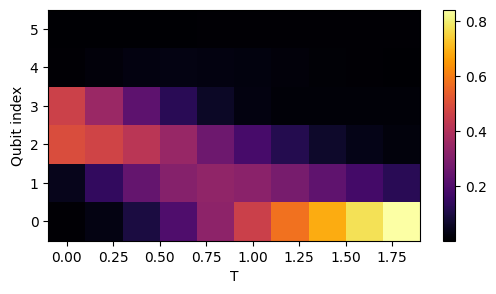

In [8]:
# For gamma = 0.5 case 
# (Full matrices and state vector based, no qiskit)
N = 6
nb_timesteps = 10
timestep_duration = 0.2
gamma = 0.5
J = 1

# Generate the unitary
matrix = get_U_HN(J, gamma , N, timestep_duration)
projection_matrix = projection(N+1)

# create the initial state vector (|↓↓↑↓↓↓⟩+|↓↓↓↑↓↓⟩)/ 2
initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)

magnetization=[]
for n_steps in range(1, nb_timesteps + 1):

    # for each time step, apply the matrix n_steps times onto the initial vector
    state_vector = np.matmul(np.linalg.matrix_power(matrix @ projection_matrix, n_steps), initial_vector).T[0]
    state_dict = {}
    for i in range(2 ** (N+1)):

        # allocate the relevant probabilities to each state
        state_dict[bin(i)[2:].zfill(N+1)] = np.abs(state_vector[i]) ** 2

   
    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in state_dict.items():

        # key[0] is the ancillary qubit
        if key[0] == '0':
            prob += value
            for i in range(1, N + 1):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i] += value

    magnetization += [[x/prob for x in row]]

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

# Adapting to Quantum Circuit Ansatz

### Mathematical Target Unitary/Hamiltonian (same as above but considering Qiskit's little endian)

(6, 10)


Text(0.5, 0, 'T')

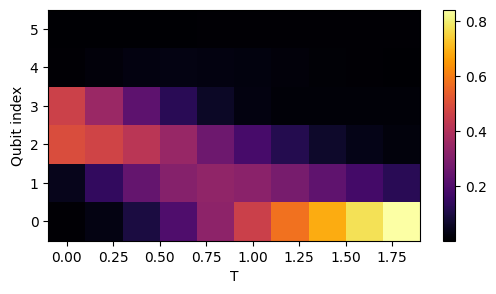

In [9]:
# For gamma = 0.5 case 
# (Full matrices and state vector based, no qiskit)
N = 6
nb_timesteps = 10
timestep_duration = 0.2
gamma = 0.5
J = 1

# Generate the unitary
matrix = get_U_HN(J, gamma , N, timestep_duration)
projection_matrix = projection(N+1)

# create the initial state vector (|↓↓↑↓↓↓⟩+|↓↓↓↑↓↓⟩)/ 2
initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)

probabilities=[]
target_states = {}
for n_steps in range(0, nb_timesteps + 1):

    # for each time step, apply the matrix n_steps times onto the initial vector
    # state_vector = np.matmul(np.linalg.matrix_power(matrix @ projection_matrix , n_steps), initial_vector).T[0]
    state_vector = np.matmul(np.linalg.matrix_power(projection_matrix @ matrix, n_steps), initial_vector).T[0]
    states = np.array([0j for i in range(2 ** (N+1))])
    probs_dict = {}

    for i in range(2 ** (N+1)):

        # allocate the relevant probabilities to each state
        # to consider little endian of qiskit:
        string = bin(i)[2:].zfill(N+1)
        string = string[1:] + string[0]
        probs_dict[string] = np.abs(state_vector[i]) ** 2
        states[int(string, 2)] = state_vector[i]
    target_states[n_steps] = states
   
    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in probs_dict.items():

        # key[0] is the ancillary qubit
        if key[-1] == '0':
            prob += value
            for i in range(0, N):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i - 1] += value
        #else:
        #    print(value)
    if n_steps > 0:
        probabilities += [[x/prob for x in row]]

probabilities = np.array(probabilities)
print(probabilities.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), probabilities.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

### Mathematical model of Quantum Circuit Ansatz
Starting state is an equal superposition of all states (H gate on all qubits)

In [10]:
def unitary_gate_matrix(theta, phi, lam):
    return np.array([[np.cos(theta/2), -np.exp(lam * 1j) * np.sin(theta/2)],
                    [np.exp(phi * 1j) * np.sin(theta/2), np.exp(1j * (phi + lam)) * np.cos(theta/2)]])

cx_matrix = np.array([[1, 0, 0, 0], 
                     [0, 0, 0, 1], 
                     [0, 0, 1, 0],
                     [0, 1, 0, 0]])

cx_matrices = np.kron(np.kron(cx_matrix, cx_matrix), cx_matrix)

cx_matrix_v1 = np.kron(np.eye(2), cx_matrices)
cx_matrix_v2 = np.kron(cx_matrices, np.eye(2))

In [11]:
def variational_circuit_mathematical(params, layers):
    stepper = 0

    #state = np.zeros((2**(N+1), 1), dtype=complex) #initial_vector.copy()
    state = np.full((2**(N+1), 1), np.sqrt(1.0/2**(N+1)))
    #state = np.zeros((2**(N+1), 1), dtype=complex)
    #state[0] = 1
    #state = initial_vector.copy()

    
    matrix = unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2])
    stepper += 1
    for _ in range(N):
        matrix = np.kron(unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2]), matrix)
        stepper += 1
    state = np.matmul(matrix, state)


    for _ in range(layers):
        state = np.matmul(cx_matrix_v1, state)
        matrix = unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2])
        stepper += 1
        for _ in range(N - 1):
            matrix = np.kron(unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2]), matrix)
            stepper += 1
        matrix = np.kron(np.eye(2), matrix)
        state = np.matmul(matrix, state)
        state = np.matmul(cx_matrix_v1, state)

        state = np.matmul(cx_matrix_v2, state)
        matrix = np.eye(2)
        for _ in range(N):
            matrix = np.kron(unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2]), matrix)
            stepper += 1
        state = np.matmul(matrix, state)
        state = np.matmul(cx_matrix_v2, state)
    
    return state
        

### Cost Function

In [12]:
def cost_function_math(params, layers, n_steps): 
    v = variational_circuit_mathematical(params, layers)     
    t = target_states[n_steps]                               
    v = v / np.linalg.norm(v)
    t = t / np.linalg.norm(t)
    overlap = np.vdot(v, t)
    return 1.0 - (overlap.conjugate() * overlap).real       


### Quantum Circuit Ansatz

In [13]:
def variational_circuit(params, layers):
    qc = QuantumCircuit(N+1)
    stepper = 0

    qc.h(range(N+1))

    # initial
    for qubit in range(N+1):
        qc.u(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2], qubit) #N - qubit)
        stepper += 1
    
    for layer in range(layers):
        # CX gates
        qc.cx(0, 1)
        qc.cx(2, 3)
        qc.cx(4, 5)

        # first set of U3 gates
        for qubit in range(N):
            qc.u(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2], qubit) 
            stepper += 1
        
        # CX gates
        qc.cx(0, 1)
        qc.cx(2, 3)
        qc.cx(4, 5)

        # CX gates
        qc.cx(1, 2)
        qc.cx(3, 4)
        qc.cx(5, 6)

        # first set of U3 gates
        for qubit in range(N):
            qc.u(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2], qubit + 1)
            stepper += 1
        
        # CX gates
        qc.cx(1, 2)
        qc.cx(3, 4)
        qc.cx(5, 6)

    qc.measure_all()

    return qc

In [14]:
def calculate_results(params):

    # initialization of the sampler
    sampler = Sampler(mode=BACKEND)
    
    # Sampler runs a job on the Bell circuit
    job = sampler.run([(variational_circuit(params))])
    job_result = job.result()
    return job_result[0].data.meas.get_counts(), job_result[0].metadata['shots']

### Simple optimization for number of layers

In [15]:
def create_params(layers):
    params = np.array([np.pi/4 for i in range(((N+1) + (N * 2 * layers)) * 3)])
    return params

def create_bounds(layers): # not used
    bounds = tuple([(0.0, np.pi) if i % 3 == 0 else (0.0, 2 * np.pi) for i in range(((N+1) + (N * 2 * layers)) * 3)])
    return bounds

In [16]:
optimal_layers = [0 for _ in range(nb_timesteps)]

In [17]:
n_steps = 3 # 1 to nb_timesteps (for reference: for n_steps in range(1, nb_timesteps + 1), nb_timesteps = 1)
print("Step number: ", n_steps)
min_cost = 1
for layers in range(1, 8+1):
    params = create_params(layers)
    sum_of_cost = 0.0
    for _ in range(2): # using 2 iterations to find average error
        res = minimize(cost_function_math, params, args=(layers, n_steps), method='L-BFGS-B') #, options={'ftol': 1E-10, 'gtol': 1E-10, 'maxfun': 100000, 'maxiter': 100000})
        sum_of_cost += cost_function_math(res.x, layers, n_steps)
    if min_cost >= sum_of_cost/5:
        optimal_layers[n_steps - 1] = layers

Step number:  3


KeyboardInterrupt: 

In [18]:
optimal_layers = [8 for _ in range(nb_timesteps)]

### Optimization of Parameters and Simulation on Simulator.

In [20]:
params_dict = {}
for n_steps in range(1, nb_timesteps + 1):
    print("Step number: ", n_steps)
    layers = optimal_layers[n_steps - 1]
    params = create_params(layers)
    res = minimize(cost_function_math, params, args=(layers, n_steps), method='L-BFGS-B', options={'ftol': 1E-10, 'gtol': 1E-10, 'maxfun': 100000, 'maxiter': 100000})
    print(cost_function_math(res.x, layers, n_steps))

    params_dict[n_steps] = res.x

Step number:  1
3.967742585575529e-05
Step number:  2
1.8822526700601472e-05
Step number:  3
6.136210321194824e-06
Step number:  4
1.0341305848093896e-05
Step number:  5
8.730220034447456e-06
Step number:  6
2.062916212153265e-05
Step number:  7
1.218826200111156e-05
Step number:  8
8.476570971915898e-06
Step number:  9
1.5226594261008586e-06
Step number:  10
1.6044179633190048e-05


In [23]:
data = []
for n_steps in range(1, nb_timesteps + 1):
    data.append(params_dict[n_steps])
    
with open('params.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(data)

{'1110110': 524, '1101110': 458, '1111010': 36, '1111100': 2, '1011110': 4}
{'1110110': 462, '1111100': 26, '1101110': 367, '1111010': 155, '1011110': 14}
{'1111010': 245, '1101110': 239, '1110110': 413, '1111100': 99, '1011110': 27, '0111110': 1}
{'1101110': 150, '1110110': 317, '1111100': 192, '1111010': 333, '1011110': 29, '0111110': 3}
{'1111100': 319, '1011110': 31, '1111010': 351, '1110110': 263, '1101110': 57, '0111110': 3}
{'1111010': 323, '1111100': 491, '1011110': 17, '1110110': 171, '1101110': 17, '0111110': 5}
{'1111010': 288, '1111100': 599, '1110110': 106, '1011110': 14, '1101110': 13, '0111110': 4}
{'1111010': 231, '1111100': 702, '1110110': 75, '1101110': 8, '1011110': 6, '0111110': 2}
{'1111100': 760, '1111010': 198, '1110110': 37, '1101110': 23, '0111110': 4, '1011110': 2}
{'1111100': 851, '1111010': 139, '1110110': 18, '0111110': 6, '1101110': 10}
(6, 10)


Text(0.5, 0, 'T')

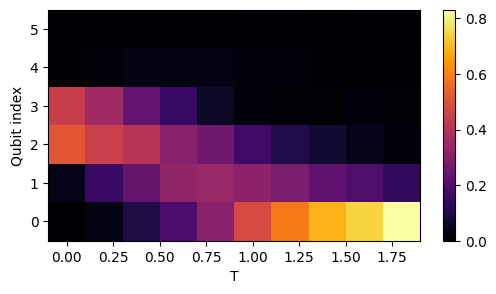

In [46]:
res_all_circuits = []
for n_steps in range(1, nb_timesteps + 1):
    res, counts = calculate_results(params_dict[n_steps])
    print(res)

    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in res.items():

        
        if key[-1] == "0":
            prob += value
            #for i in range(0, N):
            for i in range(0, N):
                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i - 1] += value

    res_all_circuits += [[x/prob for x in row]]

res_all_circuits = np.array(res_all_circuits)

print(res_all_circuits.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), res_all_circuits.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')